In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importing Libraries

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/CS 682/CS682 Project')

In [3]:
!pip install torchdiffeq
!pip install torchmetrics
!pip install torchviz
!pip install torch-fidelity

In [4]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torchmetrics.functional.multimodal import clip_score
from torchmetrics.image.fid import FrechetInceptionDistance
import pickle
from functools import partial
import torchviz
from torchviz import make_dot
import PIL
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
from torchdiffeq import odeint
import os


from caption_generation import CIFAR10WithCaptions
from unet_attn import UNet
from text_encoding import reshape_text

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [5]:
def uncond_dataset():
  transform = transforms.Compose(
    [transforms.ToTensor()])

  train_dataset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/CS 682/CS682 Project/uncond_dataset/train/', train=True,
                                          download=True, transform=transform)
  test_dataset = torchvision.datasets.CIFAR10(root='./drive/MyDrive/CS 682/CS682 Project/uncond_dataset/train/', train=False,
                                          download=True, transform=transform)
  
  class Custom_CIFAR_train(torch.utils.data.Dataset):
    def __init__(self, train_dataset):
      self.target_imgs = train_dataset
    def __getitem__(self, idx):
      return self.target_imgs[idx][0]
    def __len__(self):
      return len(train_dataset)

  flow_train_dataset = Custom_CIFAR_train(train_dataset)
  flow_test_dataset = Custom_CIFAR_train(test_dataset)

  return flow_train_dataset, flow_test_dataset

In [6]:
def cond_dataset():
  with open('/content/drive/MyDrive/CS 682/CS682 Project/CAPTIONED_CIFAR_TRAIN.pkl', 'rb') as file:
    flow_train_dataset = pickle.load(file)
  with open('/content/drive/MyDrive/CS 682/CS682 Project/CAPTIONED_CIFAR_TEST.pkl', 'rb') as file:
    flow_test_dataset = pickle.load(file)
  return flow_train_dataset, flow_test_dataset

In [7]:
def load_dataset(conditional_gen=False):
  if conditional_gen:
    return cond_dataset()
  else:
    return uncond_dataset()

### Train-Validation Split

In [8]:
def split_train_dataset(flow_train_dataset, train_frac):
  flow_train_dataset, flow_val_dataset = torch.utils.data.random_split(flow_train_dataset, [train_frac, 1-train_frac])
  return flow_train_dataset, flow_val_dataset

### Model Visualizations

In [9]:
def model_viz_print(model):
  print(model)

def model_viz_graph(model, conditional_gen=False):
  if conditional_gen:
    x = torch.rand(2,4,32,32)
    sample_caption = "Hey!"
    tokens = reshape_tokens(sample_caption)
    t = torch.FloatTensor([0.0,1.0])
    make_dot(model(t,(x, tokens))
  else:
    x = torch.rand(2,3,32,32)
    t = torch.FloatTensor([0.0,1.0])
    make_dot(model(t,x))

### Inference Code

In [22]:
def inference(model, caption=None, reshape_text=None, conditional_gen=False):
  x_0 = torch.rand(1,3,32,32).to('cuda')
  if conditional_gen:
    tokens = reshape_text(caption).to('cuda')
  t = torch.linspace(0.0,1.0,10) # To observe the change in the image

  with torch.no_grad():
      if conditional_gen:
        x_1, _ = odeint(model, (x_0, tokens), t, method='dopri5', atol=1e-5, rtol=1e-5)
      else:
        x_1 = odeint(model, x_0, t, method='dopri5', atol=1e-5, rtol=1e-5)
  return x_1[:, 0]

### Evaluation Metrics

In [11]:
def FID_CLIP_Calc(model, flow_train_dataset, flow_val_dataset, reshape_text, conditional_gen=False):

  fid = FrechetInceptionDistance(normalize=True)
  imgs = torch.tensor([])
  captions = []
  real_imgs = []
  print("Started Evaluation")
  for j in range(1):
    print(j)
    if conditional_gen:
      captions = [flow_val_dataset[x][2] for x in range(100)]
      img = inference(model, captions, reshape_text, True)
      img = (img - torch.min(img))/(torch.max(img) - torch.min(img))
    else:
      for i in range(1000):
        x_0, x_1 = flow_val_dataset[i]
        real_imgs.append(x_1)
      img = inference(model)
    imgs = torch.cat((imgs, img.cpu()))
  real_imgs = torch.from_numpy(np.stack(real_imgs, axis=0).reshape(len(real_imgs),3,32,32))
  imgs = torch.from_numpy(np.stack(imgs, axis=0).reshape(len(imgs),3,32,32))
  fid.update(real_imgs, real=True)
  fid.update(imgs, real=False)
  print("Started computing FID")
  print(f"FID: {float(fid.compute())}")
  if conditional_gen:
    clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")
    clip_score_val = clip_score_fn(imgs, captions).detach()
    clip_score_val = round(float(clip_score_val), 4)
    print(f'CLIP Score Value: {clip_score_val}')

  print('----------------------------------------------------')

### Data and Model Loading

In [17]:
flow_train_dataset, flow_test_dataset = load_dataset(conditional_gen=True)
flow_train_dataset, flow_val_dataset = split_train_dataset(flow_train_dataset, 0.98)

In [18]:
[flow_test_dataset[x][2] for x in range(3) ]

['a cat is playing with a pair of shoes',
 'the two boats are docked in the water',
 'the boat is docked at the marina']

In [15]:
model = torch.load('/content/drive/MyDrive/CS 682/CS682 Project/conditional_unet_honey_ham_epoch_96.pth')

### Model Evaluation

In [16]:
FID_CLIP_Calc(model, flow_train_dataset, flow_test_dataset, reshape_text, conditional_gen=False)

Started Evaluation
0
torch.Size([1000, 3, 32, 32])
Converting to Torch
1000
Started computing FID
FID: 385.864501953125
----------------------------------------------------


### Sample Generations

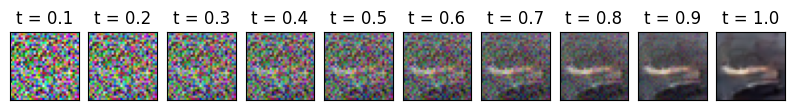

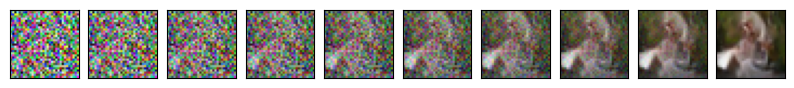

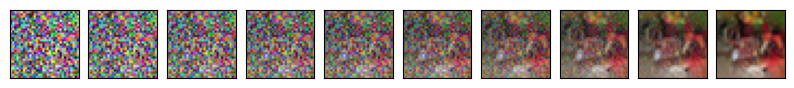

In [25]:
from matplotlib.pyplot import set_loglevel
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import math
captions  = ["'a cat is playing with a pair of shoes'", "the two boats are docked in the water", "the boat is docked at the marina"]

for i in range(3):
    infer_imgs = inference(model, captions[i], reshape_text, conditional_gen=True)
    #print(infer_imgs.shape)
    total_infers = len(infer_imgs)
    grid_cols = 10

    plt.set_loglevel("critical")

    if total_infers > 0:
      grid_rows = math.ceil(total_infers / grid_cols)

      fig = plt.figure(figsize=(grid_cols, grid_rows))
      grid = ImageGrid(fig, 111,  # similar to subplot(111)
                      nrows_ncols=(grid_rows, grid_cols),  # creates 2x2 grid of axes
                      axes_pad=0.1,  # pad between axes in inch.
                      )

      if i  == 0:
        t = .1
      for ax, im in zip(grid, infer_imgs):
          # Iterating over the grid returns the Axes.
          ax.imshow(torch.detach(im).to("cpu").permute(1,2,0))
          ax.set_xticks([])
          ax.set_yticks([])
          if i == 0:
            ax.set_title(f"t = {t:.1f}")
            t += .1

      plt.show()






### Model Size

In [22]:
sum([np.prod(p.size()) for p in model.parameters()])

191186739